__The Project__

This is a guided project provided by StrataScratch. The main goal of this project is for me to learn the steps involved in a complete Data Science Project.
By the end of this project I have become more familiar with:

- data preparation for modelling
- dealing with collinear features
- feature engineering

# DoorDash Delivery Duration Prediction

<center><img src="images/doordash-logo.png" width="200"></center>
<center><img src="images/StrataScratchLogo.png" width="200"></center>

### __Data Description__

The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

#### __Columns in historical_data.csv__

_Time features_

> - market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
> - created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
> - actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

_Store features_

> - store_id: an id representing the restaurant the order was submitted for
> - store_primary_category: cuisine category of the restaurant, e.g., italian, asian
> - order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

_Order features_

> - total_items: total number of items in the order
> - subtotal: total value of the order submitted (in cents)
> - num_distinct_items: number of distinct items included in the order
> - min_item_price: price of the item with the least cost in the order (in cents)
> - max_item_price: price of the item with the highest cost in the order (in cents)

_Market features_

> DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

> - total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
> - total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
> - total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

_Predictions from other models_

> We have predictions from other models for various stages of delivery process that we can use:

- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

#### __Practicalities__
>Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

- model(s) used, how you evaluated your model performance on the historical data,
- any data processing you performed on the data,
- feature engineering choices you made,
- other information you would like to share your modeling approach.




In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df = pd.read_csv('datasets/historical_data.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [56]:
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

In [57]:
df.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
store_primary_category                                  object
order_protocol                                         float64
total_items                                              int64
subtotal                                                 int64
num_distinct_items                                       int64
min_item_price                                           int64
max_item_price                                           int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                           int64
estimated_store_to_consumer_driving_duration           

Let us create new features from the existing features. From the existing features we can calculate for:

- Actual delivery duration
- Dashers ratio
- Estimated non-prep duration

In [58]:
# creating target variable
from datetime import datetime
df['actual_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [59]:
df['busy_dashers_ratio'] = df['total_busy_dashers']/ df['total_onshift_dashers']

In [60]:
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']

Let us deal with nominal values in our data by one-hot encoding. But first, we will check what columns can we encode to create new dummy variables.

In [61]:
df['market_id'].nunique()

6

In [62]:
df['store_id'].nunique()

6743

In [63]:
df['order_protocol'].nunique()

7

It makes sense to create a dummy variable for market_id and order_protocol but not on the store_id because of the amount of unique values that we have.

In [64]:
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [65]:
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


Imputation

Another feature that we will use for the prediction is the primary category for each store. But since we have null values, we need to impute them by using the mode of the category for each store.

In [66]:
# create dictionary with most repeated categories of each store to fill null rows where it is possible
store_id_unique = df['store_id'].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode() for store_id in store_id_unique}

In [67]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
df['nan_free_store_primary_category'] = df.store_id.apply(fill)

In [68]:
store_primary_category_dummies = pd.get_dummies(df.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Training Dataset

We are going to remove columns which we used to make other features and those that we have made a dummy variable.

In [69]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, nan_free_store_primary_category, actual_delivery_duration
train_df = df.drop(columns=["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", "nan_free_store_primary_category"])
train_df.head()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [70]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype('float32')
train_df.head()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
train_df.describe()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,2.882352,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,1.503771,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [73]:
# check infinity values using numpy infinite() function *nested function
    # x = ~np.isfinite(train_df) # check all records on all columns for non finite values
    # y = np.any(x,axis=0) # check if any of the series/columns from variable x contains True values, will return columns with True or False value
    # z = np.where(y==True)

np.where(np.any(~np.isfinite(train_df),axis=0)==True)

(array([ 0,  6,  7,  8, 10, 11, 12, 13], dtype=int64),)

In [74]:
#replace inf
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#drop all nans
train_df.dropna(inplace=True)

In [75]:
train_df.shape

(176166, 101)

In [76]:
#Generate a mask to remove the other symmetrical side of the correlation matrix
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

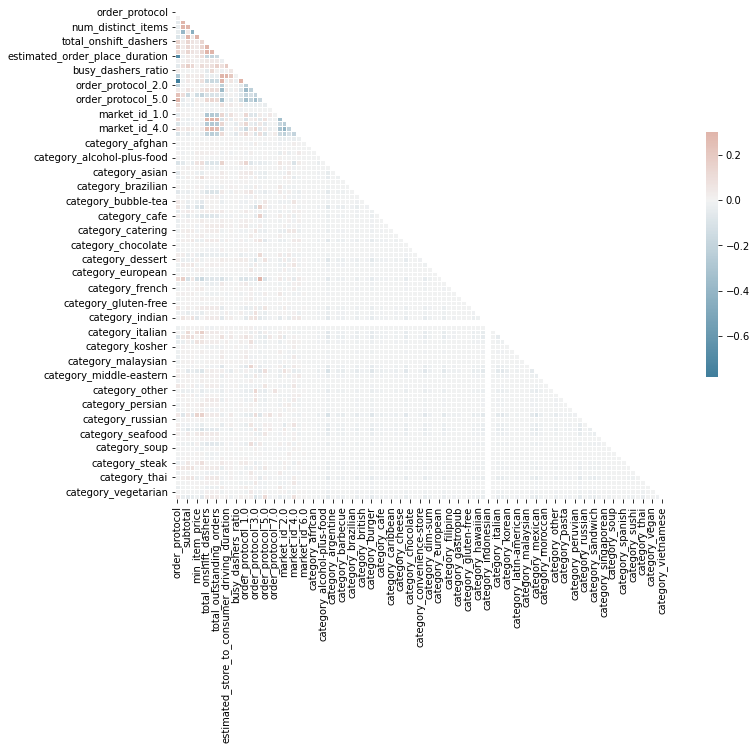

In [77]:
# Setup matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))
# Generate custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [78]:
train_df['category_indonesian'].describe()

count    176166.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

### TESTING CORRELATIONS

We need to create a function that will help us identify redundant values and find top correlated values.

In [79]:
df.shape
# df.columns

(197428, 20)

In [80]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]): #iterates over the range 0 to the number of columns
        for j in range(0, i+1): #for each iteration of the loop it will return a pair (current column, to every other column)
            pairs_to_drop.add((cols[i], cols[j])) # adds to the SET therefore eliminating the duplicate pairs
    return pairs_to_drop

In [81]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [82]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers                0.941755
                                              total_outstanding_orders          0.934653
total_busy_dashers                            total_outstanding_orders          0.931312
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration       0.923067
estimated_order_place_duration                order_protocol_1.0                0.900654
order_protocol                                order_protocol_1.0                0.780826
                                              order_protocol_5.0                0.768999
total_items                                   num_distinct_items                0.757858
order_protocol                                estimated_order_place_duration    0.687007
subtotal                                      num_distinct_items                0.682964
total_items                                   subtotal                          0.55

Drop features the we used to create dummy variables and other features

In [83]:
train_df = df.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', "actual_delivery_time", "order_protocol", "nan_free_store_primary_category"])

In [84]:
#concatenate our dummy variables excluding market_id dummy because of it having high correlation value across different market_ids
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

#drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

#align datatype over dataset
train_df = train_df.astype('float32')
#replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
train_df.shape

(177070, 90)

In [86]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [87]:
train_df = df.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', "actual_delivery_time", "order_protocol", "nan_free_store_primary_category"])
#concatenate our dummy variables excluding market_id dummy because of it having high correlation value across different market_ids
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

#drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

#align datatype over dataset
train_df = train_df.astype('float32')
#replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df,20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.188418
subtotal                                      actual_delivery_duration          0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Feature Engineering

We will create new features from existing features to overcome correlation

In [89]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items']/train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

In [90]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_delivery_duration          0.15

In [91]:
train_df.shape

(177070, 82)

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [93]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factore() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

In [94]:
#apply VIF computation to all columns
features = train_df.drop(columns=["actual_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dashers_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210845
79,estimated_order_place_duration,13.472278


In [95]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print(f"I will remove {highest_vif_feature}")
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF >20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000369
2,category_belgian,1.000461
3,category_russian,1.002022
4,category_gluten-free,1.002372
...,...,...
75,category_american,4.505928
76,avg_price_per_item,5.958972
77,busy_dashers_ratio,6.357889
78,estimated_store_to_consumer_driving_duration,7.192644


In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = train_df[selected_features]
y=train_df["actual_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)



In [110]:
# doordash_model = RandomForestRegressor()
# doordash_model.fit(X_train, X_test, y_train, y_test)
X.shape


(177070, 80)

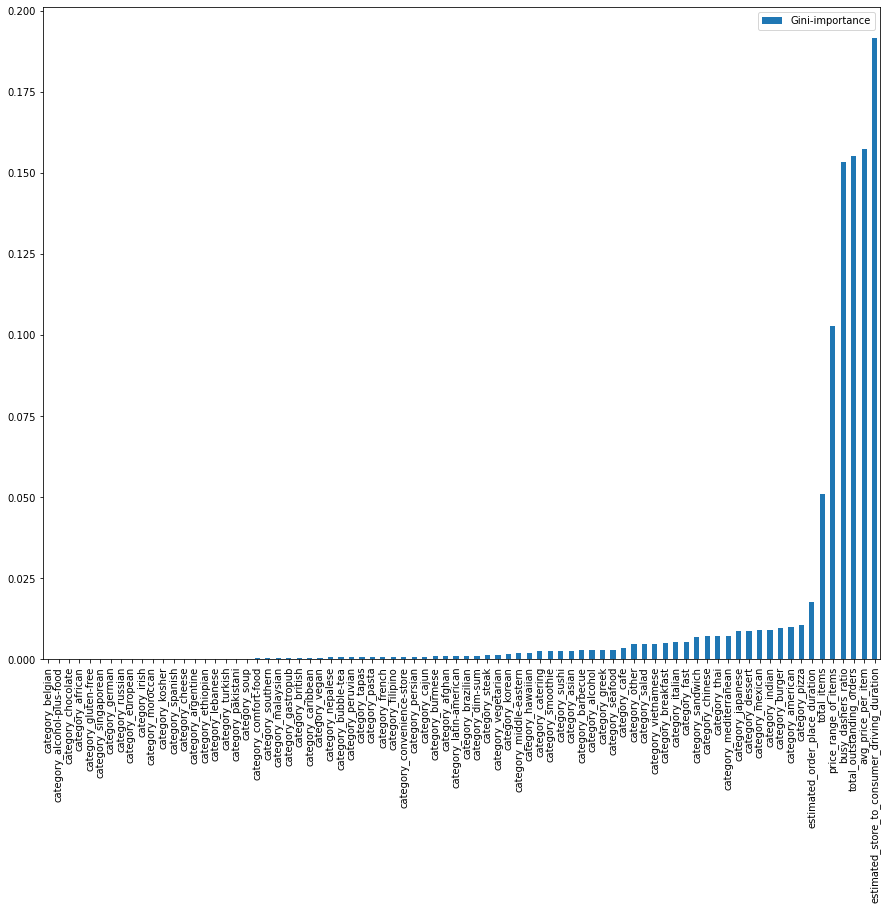

In [109]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold a feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance # add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [111]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

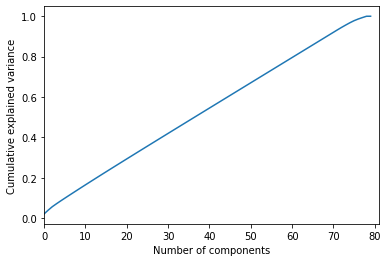

In [112]:
#PCA helps us find optimum number of features for our dataset.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train = X_train.values
X_Train = np.asarray(X_Train)

#Finding normalized array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [113]:
def scale(scaler, X, y):
    """Apply the seleced scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler

In [ ]:
#example
# X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [2]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)

    return rmse_error, y_predict